In [8]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint

In [9]:
t_sample = 0.01
T = 10

time_points = torch.linspace(0, T, int(T/t_sample)+1)


theta_act = -0.2
x0_act = 1.0

theta_act = torch.tensor(theta_act, dtype=torch.float32)
x0_act = torch.tensor(x0_act, dtype=torch.float32)

In [10]:
class ODE(nn.Module):

    def __init__(self, theta):
        super().__init__()
        self.theta = theta

    def forward(self, t, y):
        return self.theta*y

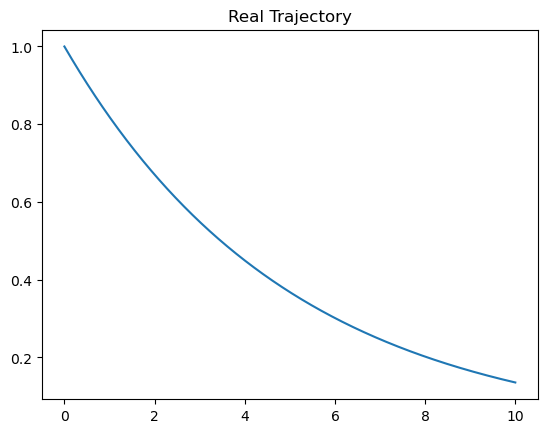

In [11]:
y_act = odeint(ODE(theta_act), x0_act, time_points)

plt.title("Real Trajectory")
plt.plot(time_points, y_act)
plt.show()

In [12]:
# Define the objective function
def objective_function(theta_hat, initial_condition, observed_data, time_points):
    # Integrate the ODE model with current parameters
    predicted_data = odeint(ODE(theta_hat), initial_condition, time_points)
    # Compute discrepancy between observed and predicted data
    return nn.MSELoss()(predicted_data, observed_data)

In [13]:
theta_hat = torch.tensor(0, dtype=torch.float32, requires_grad=True)
initial_condition = torch.tensor(0, dtype=torch.float32, requires_grad=True)

optimizer = optim.Adam([theta_hat, initial_condition], lr=0.01)

num_epochs = 300

losses = []
thetas = []
inits = []

# Optimization loop
for epoch in range(num_epochs):
    # Compute loss
    loss = objective_function(theta_hat, initial_condition, y_act, time_points)
    # Zero gradients
    optimizer.zero_grad()
    # Backpropagation
    loss.backward()
    # Update parameters
    optimizer.step()

    losses.append(loss.detach().item())
    thetas.append(theta_hat.detach().item())
    inits.append(initial_condition.detach().item())

# Obtain the learned parameters
learned_parameters = theta_hat.detach().numpy()
learned_init = initial_condition.detach().numpy()

losses = np.array(losses)
thetas = np.array(thetas)
inits = np.array(inits)

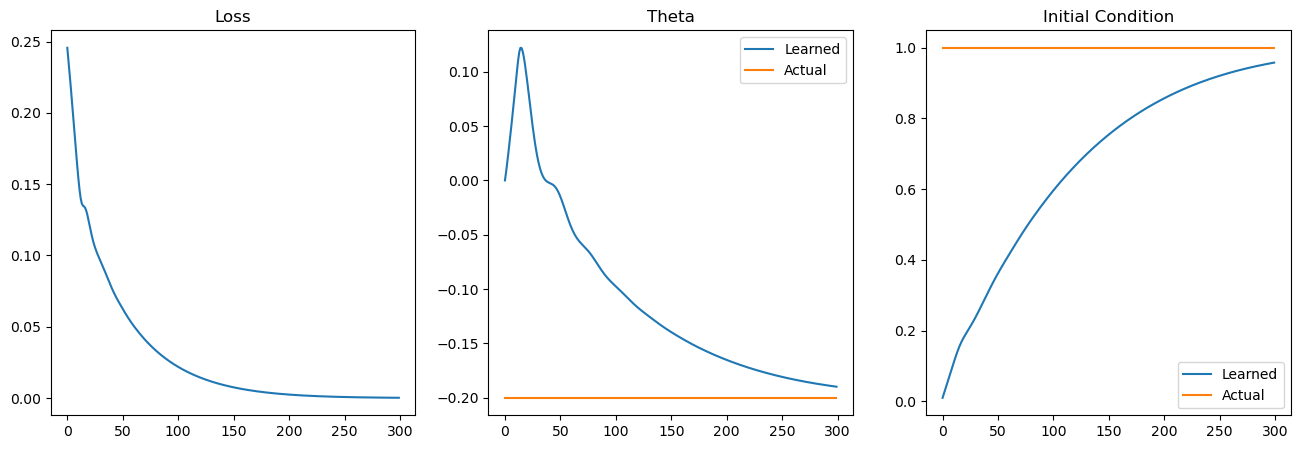

In [14]:
plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
plt.title("Loss")
plt.plot(losses)

plt.subplot(1,3,2)
plt.title("Theta")
plt.plot(thetas, label="Learned")
plt.plot(thetas*0+theta_act.item(), label="Actual")
plt.legend()

plt.subplot(1,3,3)
plt.title("Initial Condition")
plt.plot(inits, label="Learned")
plt.plot(inits*0+x0_act.item(), label="Actual")
plt.legend()